In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.transforms as transforms
base_dir = "/kaggle/input/preprocessed-oasis/keras_png_slices_data"

In [9]:
class BrainDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img

In [10]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),

])
image_dir =  os.path.join(base_dir,"keras_png_slices_train")
dataset = BrainDataset(image_dir, transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)


In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=1, feature_map=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_map*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map*8, feature_map*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map*4, feature_map*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map*2, feature_map, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_map=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_map, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map, feature_map*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map*2, feature_map*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)  # [B,1,H,W]
        return out.view(x.size(0), -1).mean(1)  # [B] for BCE loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
criterion = nn.BCELoss()

# Fixed noise for monitoring progress
fixed_noise = torch.randn(16, latent_dim,1,1, device=device)


In [14]:
epochs = 60
G_losses, D_losses = [], []

for epoch in range(epochs):
    for i, real_imgs in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        valid = torch.ones(batch_size, device=device)
        fake  = torch.zeros(batch_size, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        z = torch.randn(batch_size, latent_dim,1,1, device=device)
        fake_imgs = G(z)
        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = criterion(D_real, valid) + criterion(D_fake, fake)
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, valid)
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

    # Save generated images every 5 epochs
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            fake_imgs = G(fixed_noise).detach().cpu()
        save_image(fake_imgs, f"generated_epoch_{epoch+1}.png", nrow=4, normalize=True)


Epoch [1/60] Loss_D: 0.3146, Loss_G: 2.0419
Epoch [2/60] Loss_D: 0.5533, Loss_G: 1.6669
Epoch [3/60] Loss_D: 0.4536, Loss_G: 1.6972
Epoch [4/60] Loss_D: 1.0081, Loss_G: 0.9238
Epoch [5/60] Loss_D: 0.2259, Loss_G: 2.5214
Epoch [6/60] Loss_D: 0.1889, Loss_G: 4.7961
Epoch [7/60] Loss_D: 0.1504, Loss_G: 3.8650
Epoch [8/60] Loss_D: 0.1128, Loss_G: 3.4483
Epoch [9/60] Loss_D: 0.1002, Loss_G: 4.2309
Epoch [10/60] Loss_D: 0.2741, Loss_G: 3.1384
Epoch [11/60] Loss_D: 0.0661, Loss_G: 3.9610
Epoch [12/60] Loss_D: 0.0466, Loss_G: 3.4546
Epoch [13/60] Loss_D: 0.0340, Loss_G: 5.4399
Epoch [14/60] Loss_D: 0.0583, Loss_G: 3.4733
Epoch [15/60] Loss_D: 0.1259, Loss_G: 3.5156
Epoch [16/60] Loss_D: 0.0862, Loss_G: 4.1553
Epoch [17/60] Loss_D: 0.0721, Loss_G: 3.9696
Epoch [18/60] Loss_D: 0.3778, Loss_G: 2.6564
Epoch [19/60] Loss_D: 0.0319, Loss_G: 5.2785
Epoch [20/60] Loss_D: 0.0901, Loss_G: 3.9020
Epoch [21/60] Loss_D: 0.5046, Loss_G: 1.1602
Epoch [22/60] Loss_D: 0.3746, Loss_G: 3.4945
Epoch [23/60] Loss_

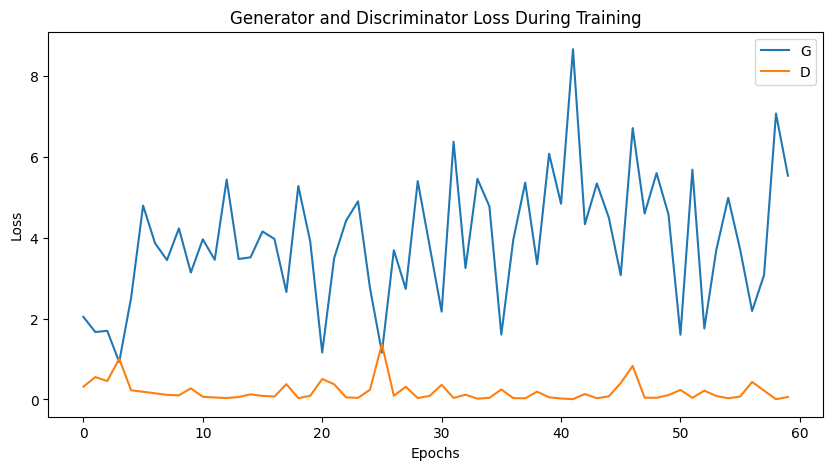

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Saved 16 generated brains to generated_brains_demo.png


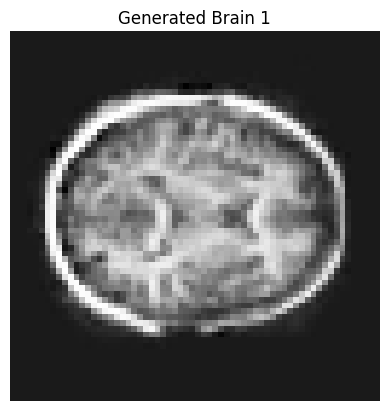

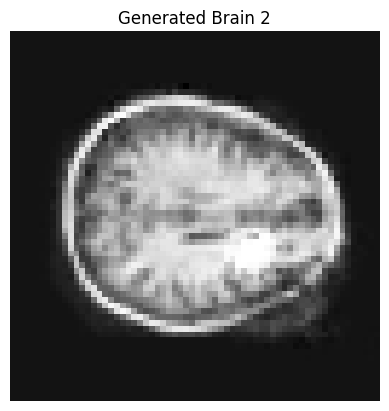

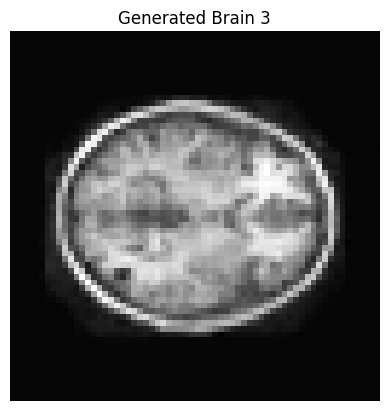

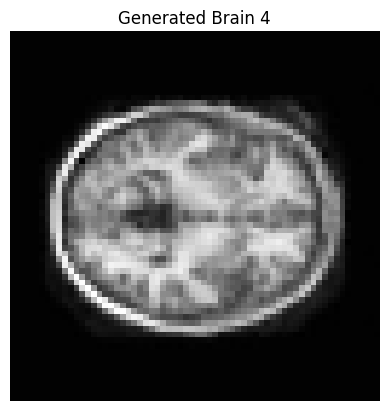

In [16]:
def generate_brains(num_images=16, save_path="generated_brains.png"):
    """
    Generates new brain MR slices using the trained Generator.

    Args:
        num_images (int): Number of images to generate.
        save_path (str): File path to save the generated image grid.
    """
    G.eval()  # Set Generator to evaluation mode
    latent_vectors = torch.randn(num_images, latent_dim, 1, 1, device=device)

    with torch.no_grad():
        fake_brains = G(latent_vectors)

    # Normalize images to [0,1] for visualization
    fake_brains = (fake_brains + 1) / 2

    # Save as grid
    save_image(fake_brains, save_path, nrow=4, normalize=True)
    print(f"Saved {num_images} generated brains to {save_path}")

    # Optional: display a few generated images
    for i in range(min(4, num_images)):
        plt.imshow(fake_brains[i,0].cpu(), cmap='gray')
        plt.title(f"Generated Brain {i+1}")
        plt.axis('off')
        plt.show()

# -------------------------
# Example usage:
# -------------------------
generate_brains(num_images=16, save_path="generated_brains_demo.png")
